In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
torch.manual_seed(69)
device

'mps'

# Convolutional model dissection

The notebook is classic dissection exercise of looking inside CNN.  
We're going to use a simple architecture and train for highly biased synthetic data in order to accentuate how CNN learns patterns.  
It will be single-batch training. The architecture is based on the popular approach:  
- CNN with kernel size of 3, stride 1 and padding to preserve the dimensions
- Relu
- MaxPool with kernel size of 2 and stride 2

Then data will be flattened and forwarded into regression/classification Dense layer.  
There are going to be 2 such layers with increasing size of channels: [4, 8].  
Additionally, we'll implement additional utility method to return outputs for each filter map, to visualize activations.  

Model will be re-trained for few examples to observe the differences:
- single symbol in the middle - 99 empty (or Gaussian noise) samples + single sample with dummy feature
- single symbol in different corners - 91 empty (or Gaussian noise) samples + 9 samples with dummy feature
- two symbols in different corners - 9 samples with one symbol, 9 samples with another and 82 empty (or Gaussian noise) samples

For single symbol will be used regression model, for two symbols classification.  
Both using standard optimizers and loss functions configuration (Sigmoid->MSELoss for regression and LogSoftmax+NLLLoss->RMSProp for classification).

We're going to visualize:
- CNN filter weights 
- activations of the filter maps for significant samples
- heatmap for training data


Gaussian noise can be enabled/disabled by changing NOISE variable.


In [3]:
NOISE=False # switch True/False to enable/disable Gaussian noise in input samples

## Model architecture

In [4]:
class CNNModule(torch.nn.Module):
    def __init__(self, output_classes=None) -> None:
        super().__init__()

        self.cnn_layer1 = torch.nn.Conv2d(1, 4, kernel_size=3, stride=1, bias=False, padding=1)
        self.max_pool1 = torch.nn.MaxPool2d(2, 2)
        self.cnn_layer2 = torch.nn.Conv2d(4, 8, kernel_size=3, stride=1, bias=False, padding=1)
        self.max_pool2 = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(8*4*4, 128)
        self.output_activation = None
        if output_classes:
            self.linear_out = torch.nn.Linear(128, output_classes)
            self.output_activation = torch.nn.LogSoftmax(dim=1)
        else:
            self.linear_out = torch.nn.Linear(128, 1)
            self.output_activation = torch.nn.Sigmoid()

    def forward(self, x):

        # CNN
        logits = self.cnn_layer1(x)
        logits = torch.relu(logits)
        logits = self.max_pool1(logits)

        logits = self.cnn_layer2(logits)
        logits = torch.relu(logits)
        logits = self.max_pool2(logits)

        # classification
        logits = self.flatten(logits)
        logits = self.linear1(logits)
        logits = torch.relu(logits)

        # output
        logits = self.linear_out(logits)
        if self.output_activation:
            logits = self.output_activation(logits)
        return logits

    def extract_features(self, x):
        # Define the forward pass
        intermediate_outputs = {}

        for name, layer in self.named_children():
            x = layer(x)
            if layer.__class__.__name__ in ["Conv2d", "MaxPool2d"]:
                print(f"extracting: {layer.__class__.__name__}")
                intermediate_outputs[name] = x

        print(f"extracting: {layer.__class__.__name__}")
        intermediate_outputs[name] = x
        return intermediate_outputs



In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_inputs, data_labels, dtype=torch.float32):
        self.inputs = data_inputs
        self.labels = data_labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        X = self.inputs[idx]
        Y = self.labels[idx]
        return X, Y

## Dataset scenarios

### 1st scenario - single symbol in fixed place

Define DS
We're generating one sample with "X" symbol, the rest will contain Gaussian noise.  

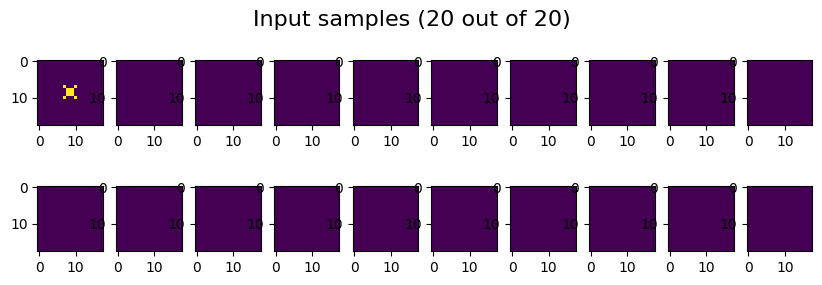

In [6]:
ds_size = 20
symbol_0 = torch.tensor([
                         [1, 0, 0, 1],
                         [0, 1, 1, 0],
                         [0, 1, 1, 0],
                         [1, 0, 0, 1]])
if NOISE:
    X = (torch.rand((ds_size, 18, 18)))/2
else:
    X = (torch.zeros((ds_size, 18, 18)))
Y = torch.zeros((ds_size, 1))

# include single symbol in half of the  samples
X[0, 7:11, 7:11] = symbol_0
Y[0] = 1

# dataloader
dataset = CustomDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=ds_size, shuffle=True)

# print first few input samples
print_sample_rows = 2
print_sample_columns = 10
def print_samples(X, print_sample_rows, print_sample_columns):
    x_nograd = X.cpu().detach().numpy()
    fig, ax = plt.subplots(print_sample_rows, print_sample_columns, figsize=(10, 3))
    fig.suptitle(f"Input samples ({print_sample_columns*print_sample_rows} out of {len(X)})", fontsize=16)
    for i in range(print_sample_rows):
        for j in range(print_sample_columns):
            ax[i][j].imshow(x_nograd[print_sample_columns*i+j], vmin=0, vmax=1)

print_samples(X, print_sample_rows, print_sample_columns)

Train

In [7]:
model = CNNModule().to(device)
loss_fn = torch.nn.MSELoss()
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
epochs = 1000

for epoch in range(epochs):
    for id, (x, y) in enumerate(dataloader):
        x = x.view(-1, 1, 18, 18)
        x = x.to(device)
        y = y.to(device)

        optim.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y, y_pred)
        loss.backward(retain_graph=True)
        optim.step()

    if epoch%100 == 99 and epoch != 0:
        print(f"Epoch {epoch}, loss: {loss.item()}")

Epoch 99, loss: 0.07037968933582306
Epoch 199, loss: 0.010280768387019634
Epoch 299, loss: 0.0034601599909365177
Epoch 399, loss: 0.0017351631540805101
Epoch 499, loss: 0.0010489149717614055
Epoch 599, loss: 0.0007055558380670846
Epoch 699, loss: 0.0005084299482405186
Epoch 799, loss: 0.0003843896265607327
Epoch 899, loss: 0.00030105357291176915
Epoch 999, loss: 0.0002422434336040169


In [8]:
print("Model layer stack:")
model.named_parameters

Model layer stack:


<bound method Module.named_parameters of CNNModule(
  (cnn_layer1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_layer2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=128, out_features=128, bias=True)
  (linear_out): Linear(in_features=128, out_features=1, bias=True)
  (output_activation): Sigmoid()
)>

Conv layer weights

Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


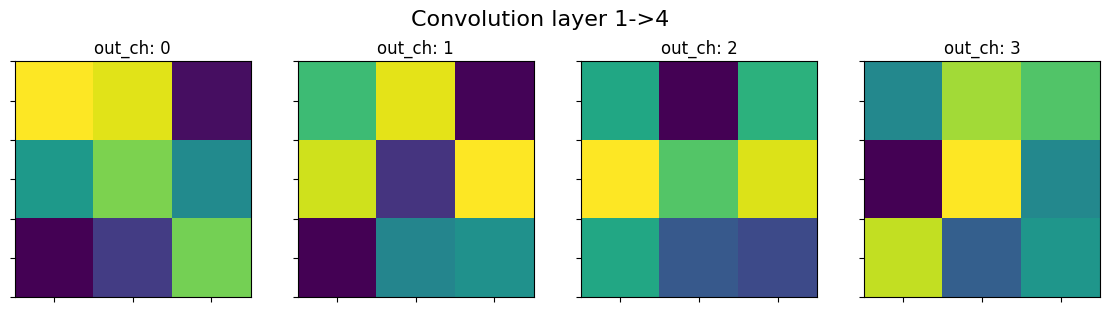

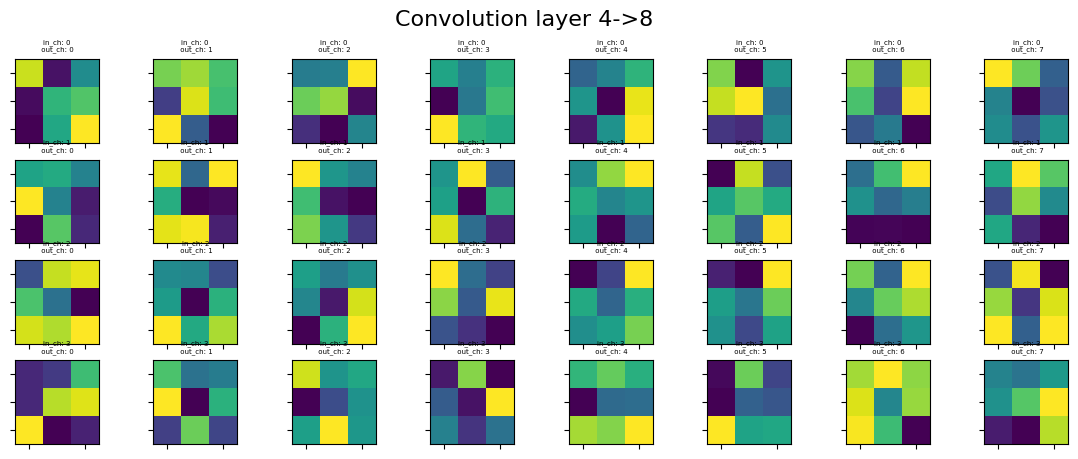

In [9]:
def display_cnn_layer(layer):
    with torch.no_grad():
        layer_shape = next(iter(layer.parameters())).shape
        out_channels_num = layer_shape[0]
        inp_channels_num = layer_shape[1]
        print(layer)
        fig, ax = plt.subplots(inp_channels_num, out_channels_num)
        fig.suptitle(f"Convolution layer {inp_channels_num}->{out_channels_num}", fontsize=16)
        fig.set_size_inches(14, 1+inp_channels_num)
        weights = list(layer.parameters())[0]
        for out_cid, channel in enumerate(weights):
            if inp_channels_num > 1:
                for inp_cid, inp_channel in enumerate(channel):
                    ax[inp_cid][out_cid].imshow(inp_channel.squeeze().cpu())
                    ax[inp_cid][out_cid].set_title(f"in_ch: {inp_cid}\n out_ch: {out_cid}", fontsize=5)
                    ax[inp_cid][out_cid].set_yticklabels([])
                    ax[inp_cid][out_cid].set_xticklabels([])
            else:
                fig.set_size_inches(14, 3.5)
                for inp_cid, inp_channel in enumerate(channel):
                    ax[out_cid].imshow(channel.squeeze().cpu())
                    ax[out_cid].set_title(f"out_ch: {out_cid}")
                    ax[out_cid].set_yticklabels([])
                    ax[out_cid].set_xticklabels([])


display_cnn_layer(model.cnn_layer1)
display_cnn_layer(model.cnn_layer2)

What we see here are 4 filters in first convolution layer and 8x4 filters (4 kernels for each input dimension) in second convolution layer.  
What that means is that every feature map takes as input all feature maps from previous conv layer and applies separate kernel on each to produce new feature map.  
So, what we call filter is that set of kernels for each feature map.  

For instance if we have grey-scale image (like here) that would mean:  

```
[input]    [conv1]    [conv2]   
18x18x1 -> 18x18x4 -> 18x18x8   

```

but technically we down-scale the feature maps each time, because we want the convolution net to detect less and less local features after applying each layer, so we apply down-scalling (max pool function in between), so it's more like this:  

```
[input]           [conv1]          [max_pool1]           [conv2]         [max_pool2]
18x18x1    -->    18x18x4     -->     9x9x4       -->     9x9x8     -->     3x3x8   

```


In terms of filters that would be:

```
[input]           [conv1]          [max_pool1]           [conv2]         [max_pool2]
18x18x1    -->    18x18x4     -->     9x9x4       -->     9x9x8     -->     3x3x8   
         3x3x1x4             2x2x4              3x3x4x8            2x2x8            
        [H W I O]           [H W O]            [H W I O]          [H W O]           

```

where HxWxIxO refers to filter's: Height of a window, Width of a window, number of feature map's input dimensions, number of feature maps.  
In this case every filter then has a size of 3x3x1 in first conv layer and 3x3x4 in second conv layer.  
3x3 is arbitrary and that's a size we use in this notebook, but it is common to use either 3x3 or 5x5.  

We also annotated 2x2x4 as the size of Max Pool windows - we pool 2x2 pixels to produce single value for each conv dimension.  
In other words we downscale by 2 across height and width, seperately for each feature map.  

So, what we see in above images are these sets of kernels:
- 1x4 - single kernel (because of grey-scale image) for each of 4 filters in first layer - they compose 4 feature maps
- 4x8 - 4 kernels (because previous conv outputted 4 dimensions) for each of 8 filters in second layer - they compose 8 feature maps

In [10]:
# print all layers
for name, layer in model.named_children():
    print(f"{name}: ", layer.__class__.__name__)

cnn_layer1:  Conv2d
max_pool1:  MaxPool2d
cnn_layer2:  Conv2d
max_pool2:  MaxPool2d
flatten:  Flatten
linear1:  Linear
linear_out:  Linear
output_activation:  Sigmoid


extracting: Conv2d
extracting: MaxPool2d
extracting: Conv2d
extracting: MaxPool2d
extracting: Sigmoid


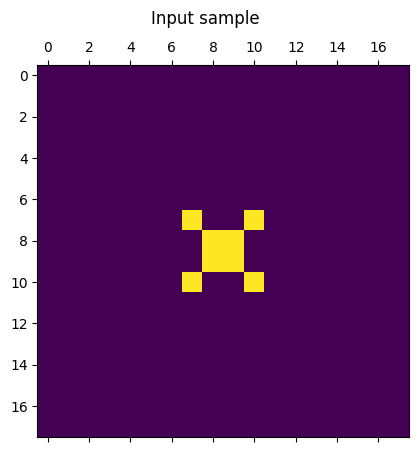

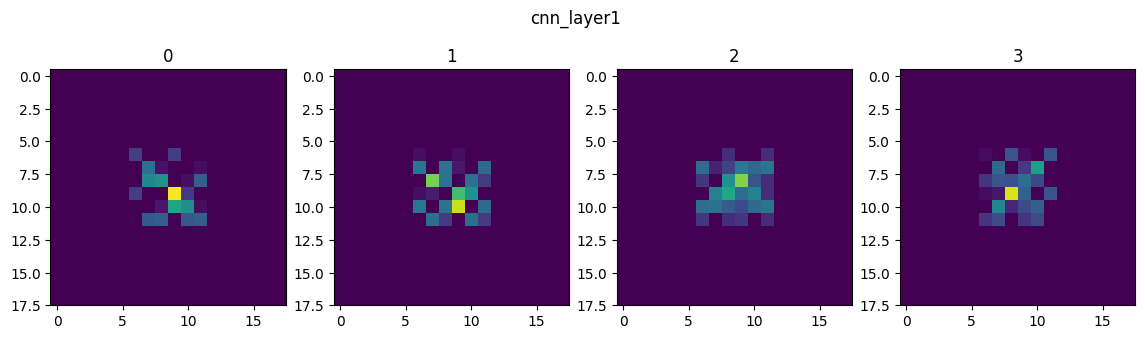

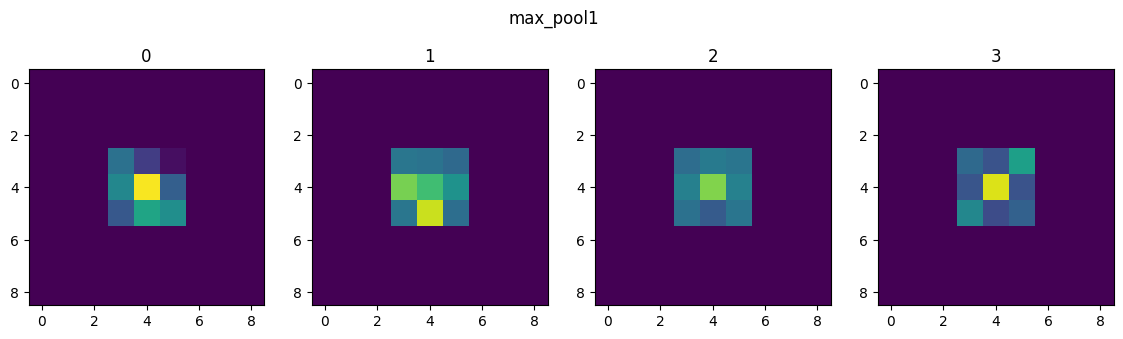

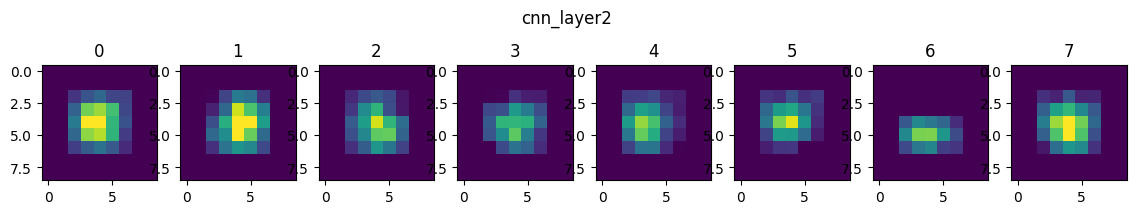

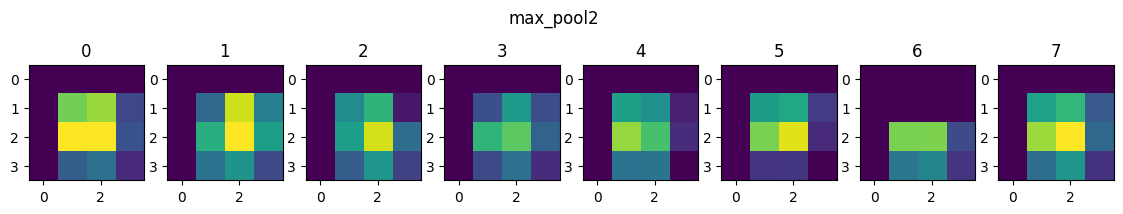

extracting: Conv2d
extracting: MaxPool2d
extracting: Conv2d
extracting: MaxPool2d
extracting: Sigmoid


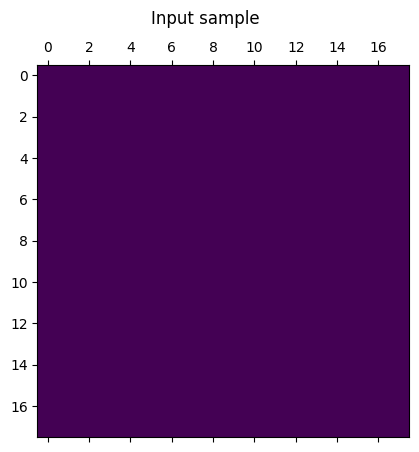

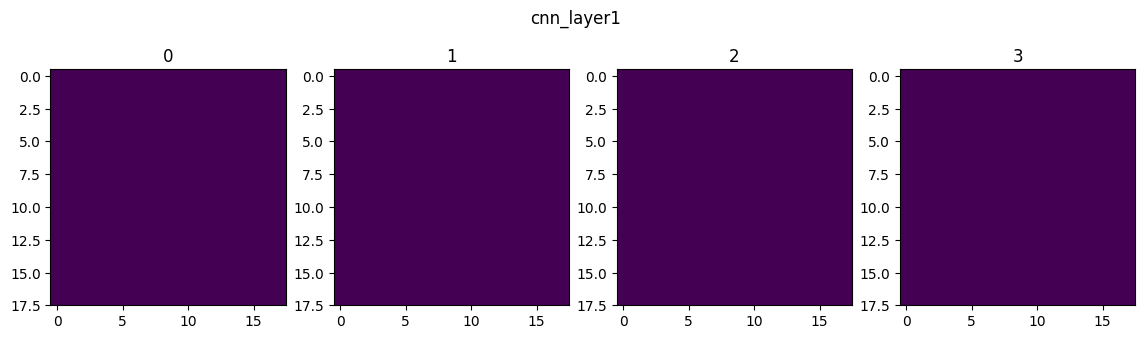

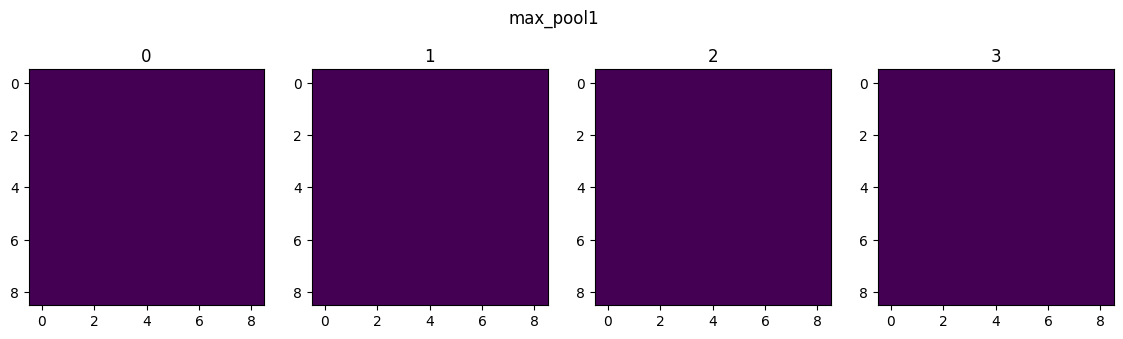

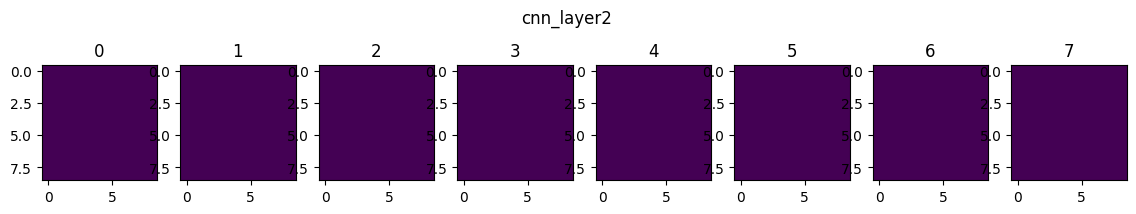

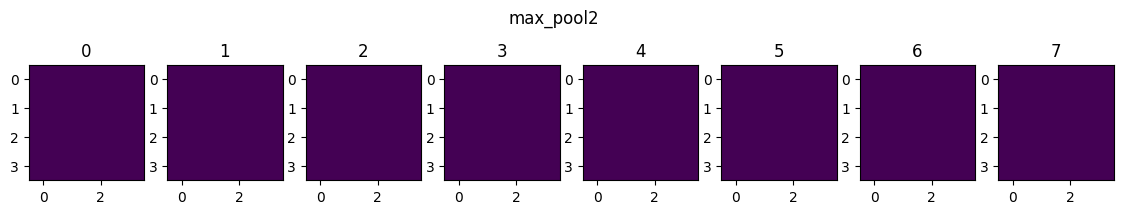

In [11]:
# util function for feature map
def display_feature_maps(sample):
    output_features = model.extract_features(sample.unsqueeze(dim=0).unsqueeze(dim=0).to(device))
    #print(output_features)
    output_features = {name: feat for name, feat in output_features.items() if name != 'output_activation'}
    plt.matshow(sample.cpu().detach().numpy(), vmin=0, vmax=1)
    plt.suptitle('Input sample', fontsize=12)
    for layer_id, item in enumerate(output_features.items()):
        name, layer_tensors = item[0], item[1].cpu().detach().squeeze(dim=0).numpy()
        fig, ax = plt.subplots(1, layer_tensors.shape[0])
        fig.suptitle(name, fontsize=12)
        fig.set_size_inches(14, np.max([1.0, 5.0-(len(layer_tensors)/3)])) # this size is arbitrary, it might break if you try to add more layers
        for tid, tensor in enumerate(layer_tensors):
            ax[tid].imshow(tensor, vmin=0, vmax=1)
            ax[tid].axes.set_title(tid)

    plt.show()

samples = [X[0], X[10]]
for sample in samples:
    # generate activations only for Conv2d and MaxPool2d layers
    display_feature_maps(sample)

As one could expect: no activations for empty input and different patterns for activations of different filters given a non-empty sample.   

### 2nd scenario - single symbol in different places

Define DS  
We're generating 9 samples with symbol "X", the rest will contain Gaussian noise.  

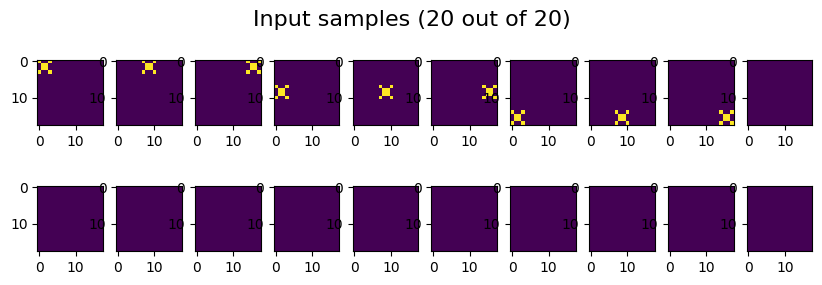

In [12]:
# generate random samples
if NOISE:
    X = (torch.rand((ds_size, 18, 18)))/2
else:
    X = (torch.zeros((ds_size, 18, 18)))/2
Y = torch.zeros((ds_size, 1))

# include same symbol in different pleaces
for i in range(3):
    for j in range(3):
        X[3*i+j, (i*6+(i)):(i*6+(i)+4), (j*6+(j)):(j*6+(j)+4)] = symbol_0
        Y[3*i+j] = 1

# dataloader
dataset = CustomDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=ds_size, shuffle=True)

print_samples(X, print_sample_rows, print_sample_columns)

Train

In [13]:
model = CNNModule().to(device)
loss_fn = torch.nn.MSELoss()
optim = torch.optim.AdamW(model.parameters(), lr=1e-2)
epochs = 2000

for epoch in range(epochs):
    for id, (x, y) in enumerate(dataloader):
        x = x.view(-1, 1, 18, 18)
        x = x.to(device)
        y = y.to(device)

        optim.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y, y_pred)
        loss.backward(retain_graph=True)
        optim.step()

    if epoch%200 == 199 and epoch != 0:
        print(f"Epoch {epoch}, loss: {loss.item()}")

model.eval()

Epoch 199, loss: 3.3095868275268e-05
Epoch 399, loss: 1.7634520190767944e-05
Epoch 599, loss: 1.1221148270124104e-05
Epoch 799, loss: 8.026860996324103e-06
Epoch 999, loss: 6.173559995659161e-06
Epoch 1199, loss: 4.973621798853856e-06
Epoch 1399, loss: 4.132099093112629e-06
Epoch 1599, loss: 3.5059354104305385e-06
Epoch 1799, loss: 3.0188318760338007e-06
Epoch 1999, loss: 2.6269919999322155e-06


CNNModule(
  (cnn_layer1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_layer2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=128, out_features=128, bias=True)
  (linear_out): Linear(in_features=128, out_features=1, bias=True)
  (output_activation): Sigmoid()
)

Conv layer weights

Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


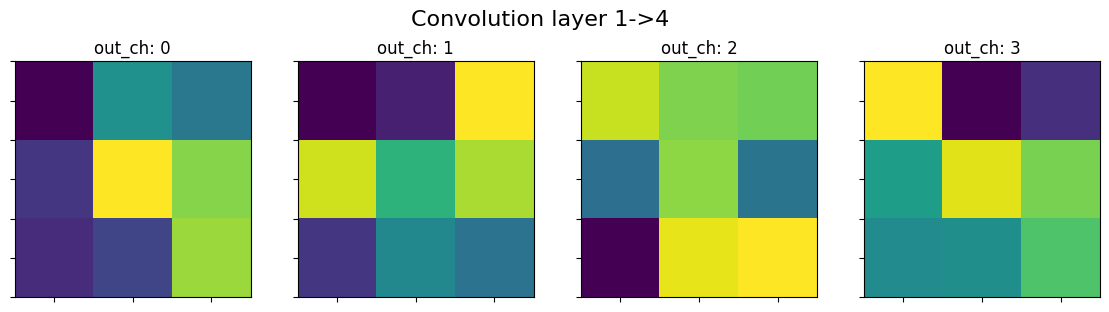

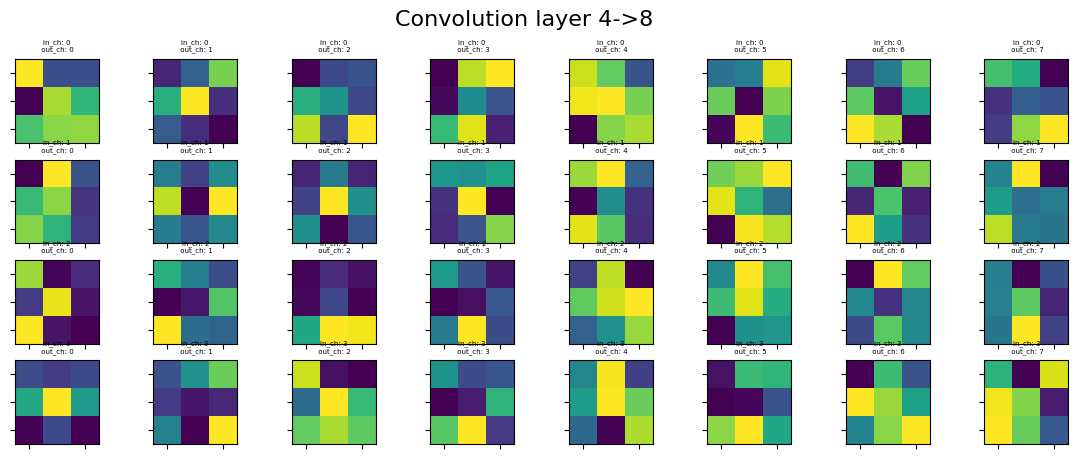

In [14]:
display_cnn_layer(model.cnn_layer1)
display_cnn_layer(model.cnn_layer2)

extracting: Conv2d
extracting: MaxPool2d
extracting: Conv2d
extracting: MaxPool2d
extracting: Sigmoid


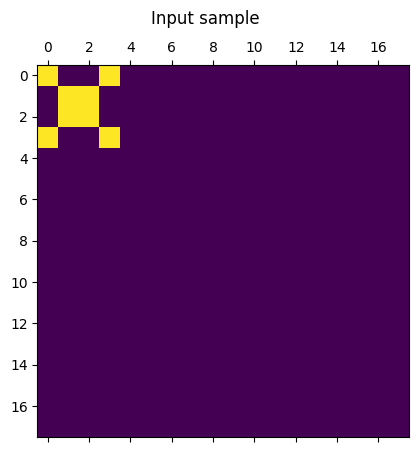

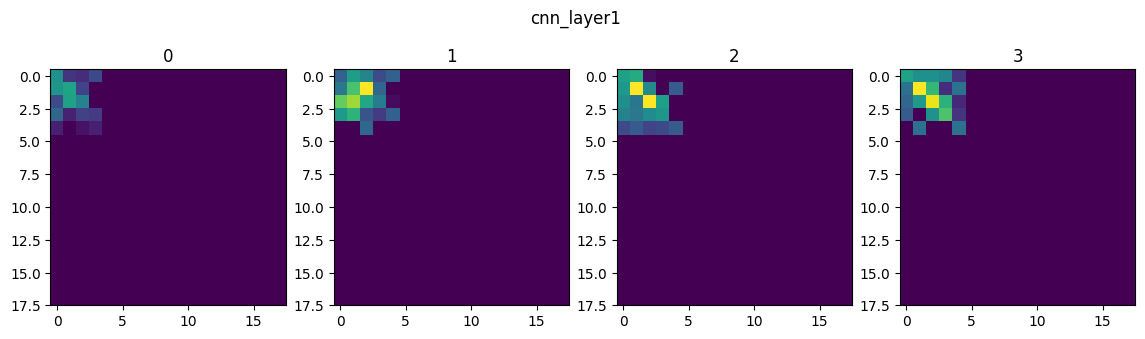

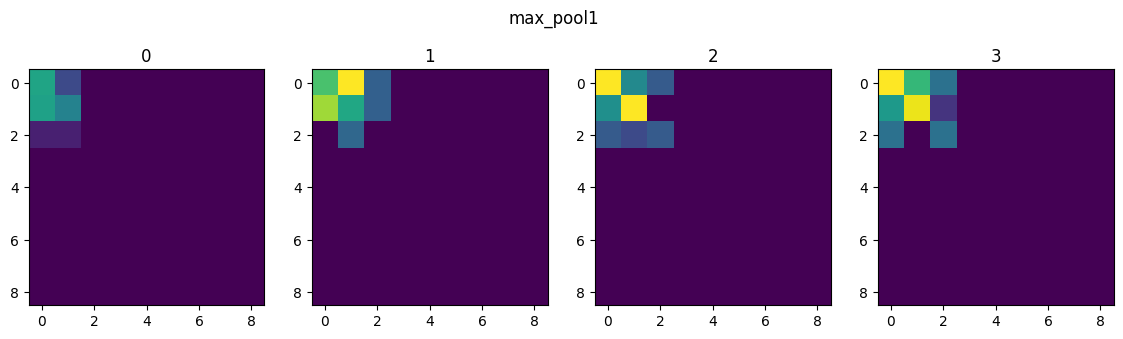

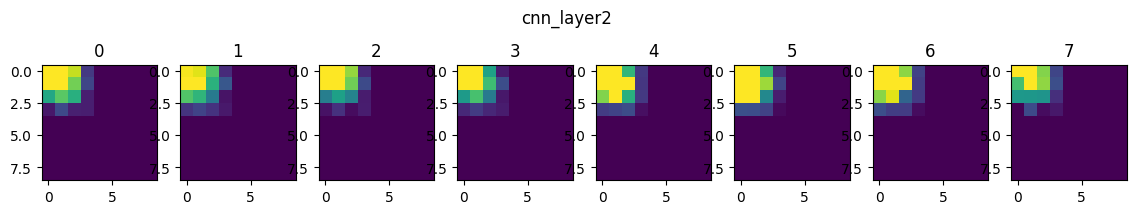

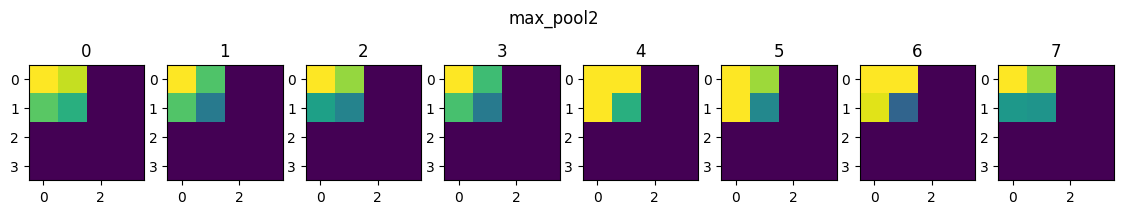

extracting: Conv2d
extracting: MaxPool2d
extracting: Conv2d
extracting: MaxPool2d
extracting: Sigmoid


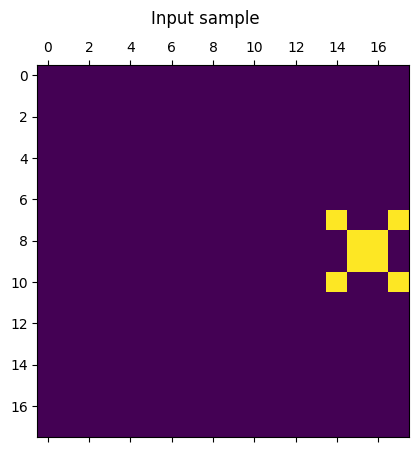

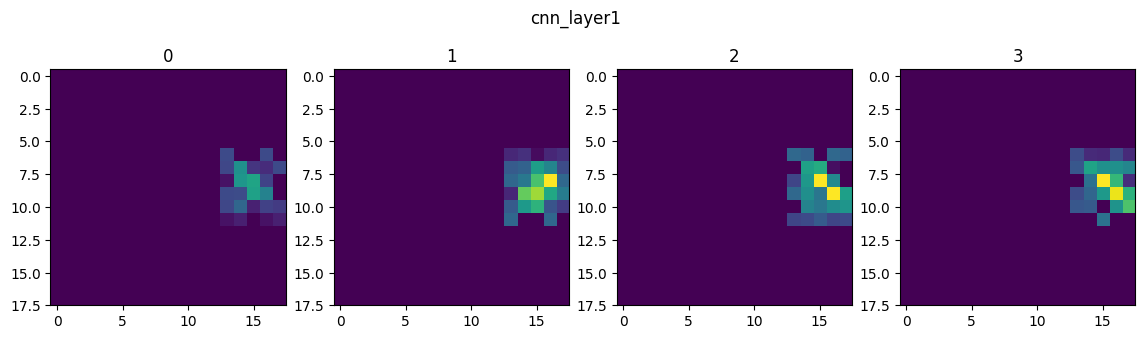

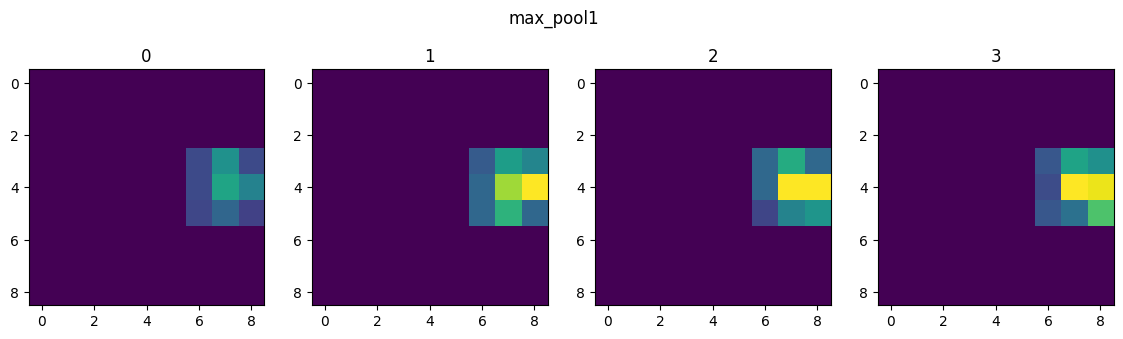

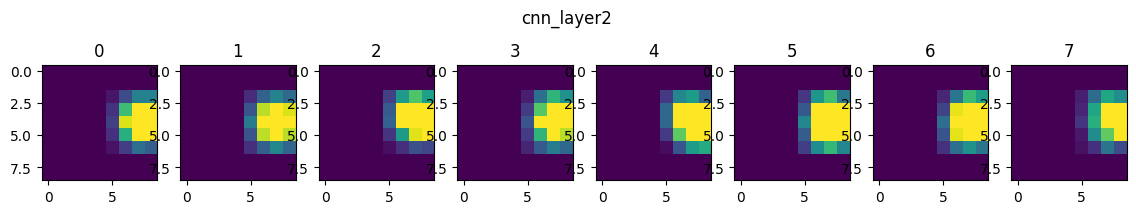

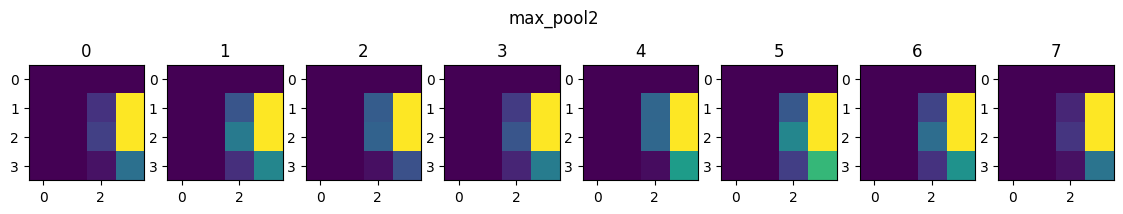

In [15]:
samples = [X[0], X[5]]
for sample in samples:
    # generate activations only for Conv2d and MaxPool2d layers
    display_feature_maps(sample)

What is apparent in this scenario is that kernels for filters 0, 2, 3 in first convolutional layer (see "Convolution Layer 1->4") activate on diagonal, although 2 and 3 are more similar to each other - the capture all thee pixels on diagonal.  
That same is not a case in 1st filter, which detects horizontal line instead.    
The result is that when we look at the feature maps for different filters (see "cnn_layer1") we can see similar patterns 2 and 3, highly activated on diagonal and similar for filter 0 - but to much lower extend. Meanwhile for filter 1 we can see completely different activation.  

The same patterns are visible independent on where the input shape is. Compared sample "X" is placed in position top-left, then right and presents the same activations, though in different places of given filters. It shows that each filter is detecting local shapes globally.  

### 3rd scenario - two symbols (two classes)

Define DS  
In this example, on top of low-level patterns, we're generating additional pattern composed of low-level ones.  
We're generating 9 samples with symbol "X" and 9 samples with symbol "O", the rest will contain Gaussian noise.  

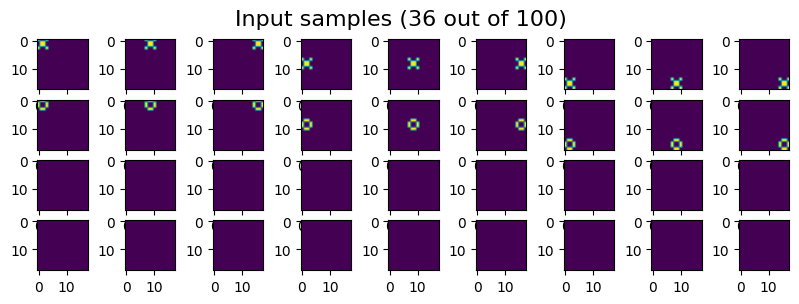

In [16]:
symbol_1 = torch.tensor([
                         [0, 1, 1, 0],
                         [1, 0, 0, 1],
                         [1, 0, 0, 1],
                         [0, 1, 1, 0]])

# generate random samples
ds_size = 100
num_classes = 3
if NOISE:
    X = (torch.rand((ds_size, 18, 18), requires_grad=True))/2
else:
    X = (torch.zeros((ds_size, 18, 18), requires_grad=True))/2
Y = torch.zeros(ds_size)

# include X symbol
for i in range(3):
    for j in range(3):
        X[3*i+j, (i*6+(i)):(i*6+(i)+4), (j*6+(j)):(j*6+(j)+4)] = symbol_0
        Y[3*i+j] = torch.tensor([1])

# include O symbol
for i in range(3):
    for j in range(3):
        X[3*i+j+9, (i*6+(i)):(i*6+(i)+4), (j*6+(j)):(j*6+(j)+4)] = symbol_1
        Y[3*i+j+9] = torch.tensor([2])

# dataloader
dataset = CustomDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=ds_size, shuffle=False)

print_samples(X, 4, 9)

For next scenario, we do not retrain the model, because we want to compare same filters :)

Conv layer weights

Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


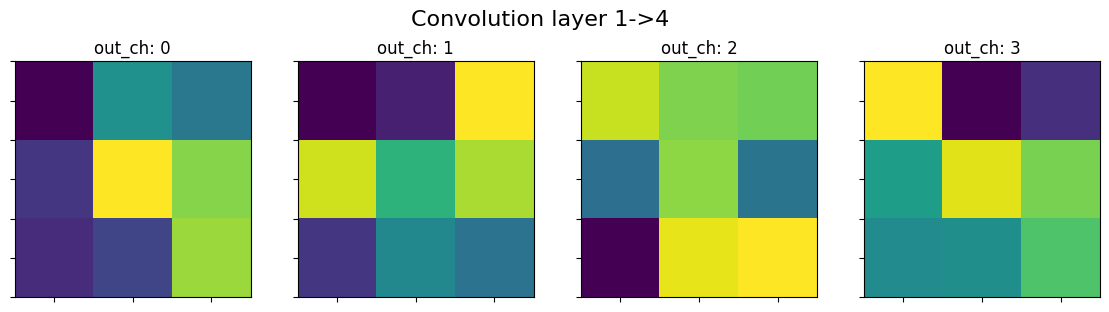

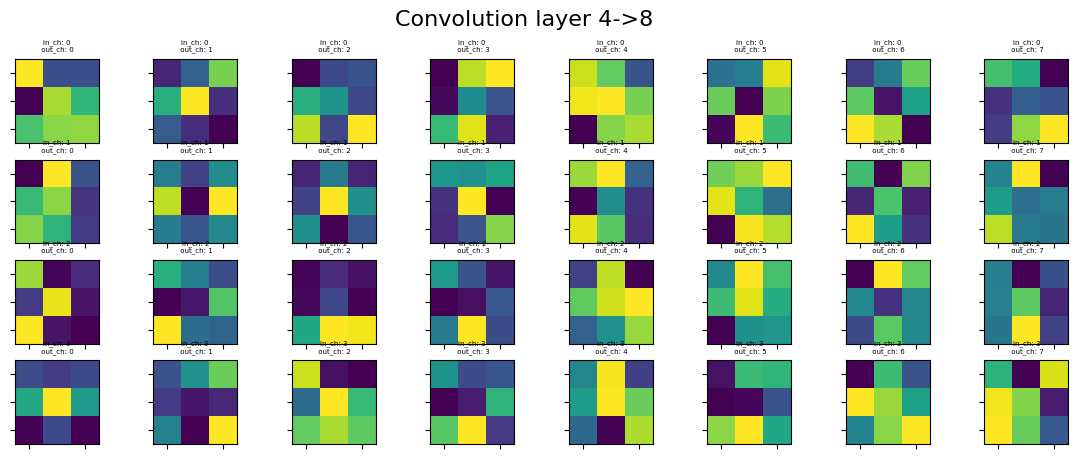

In [17]:
display_cnn_layer(model.cnn_layer1)
display_cnn_layer(model.cnn_layer2)

extracting: Conv2d
extracting: MaxPool2d
extracting: Conv2d
extracting: MaxPool2d
extracting: Sigmoid


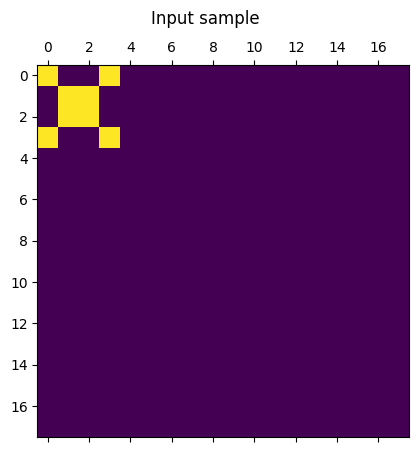

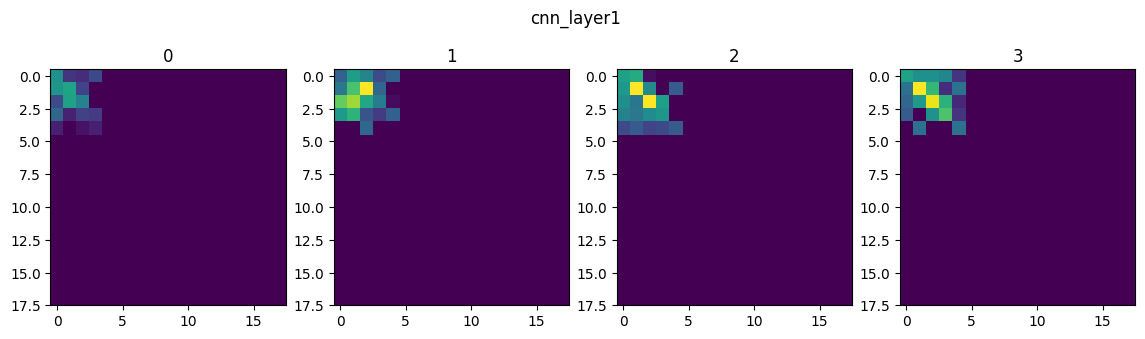

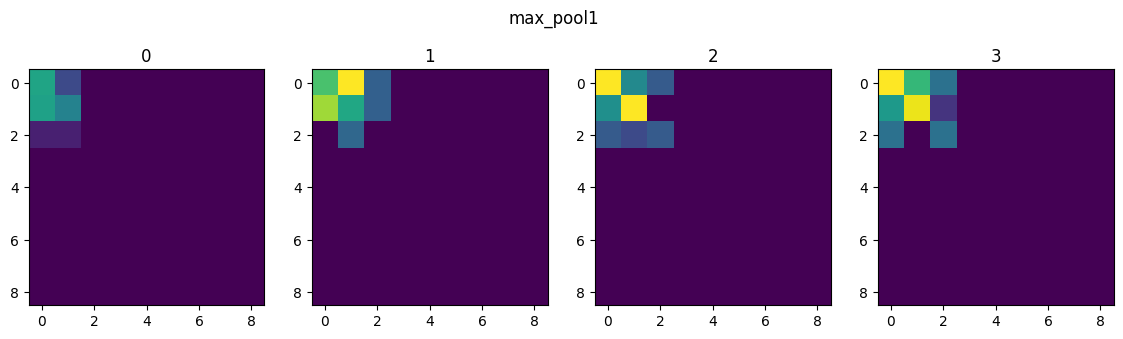

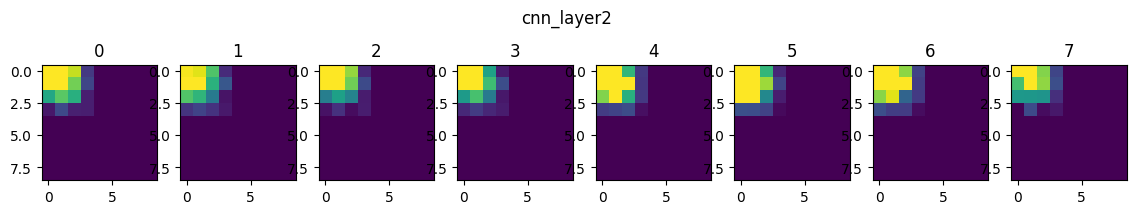

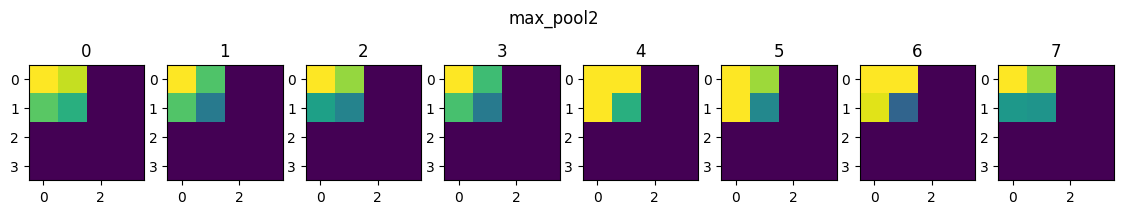

extracting: Conv2d
extracting: MaxPool2d
extracting: Conv2d
extracting: MaxPool2d
extracting: Sigmoid


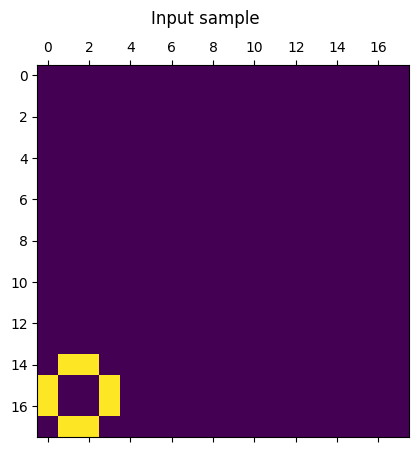

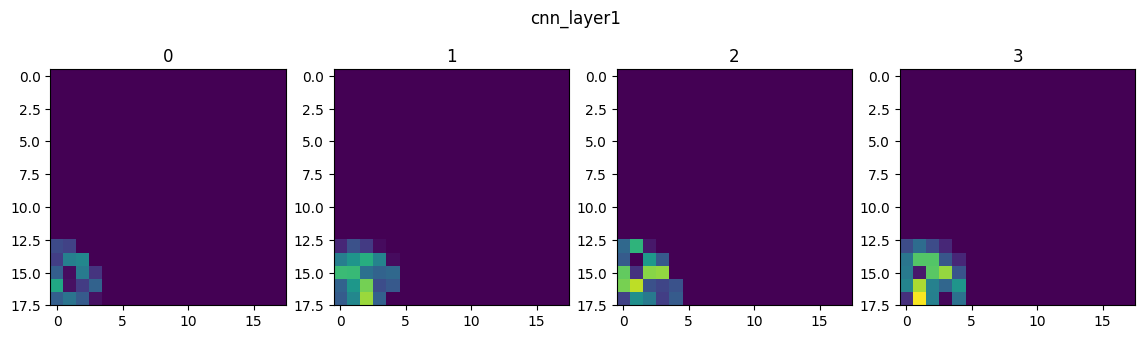

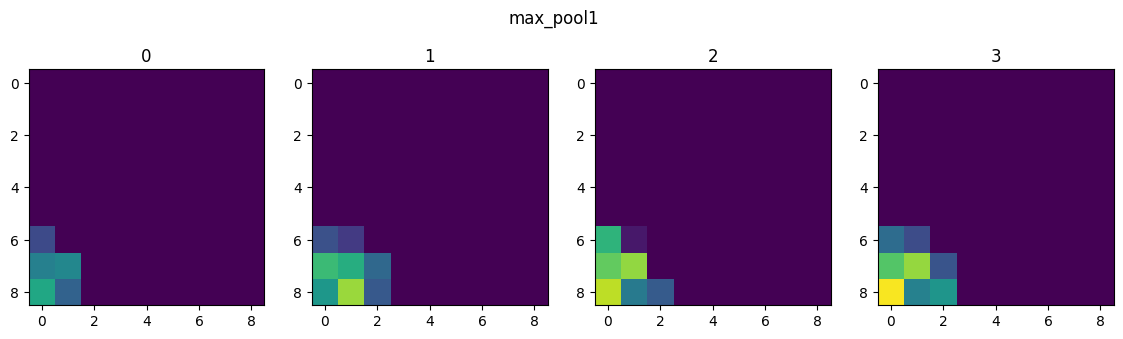

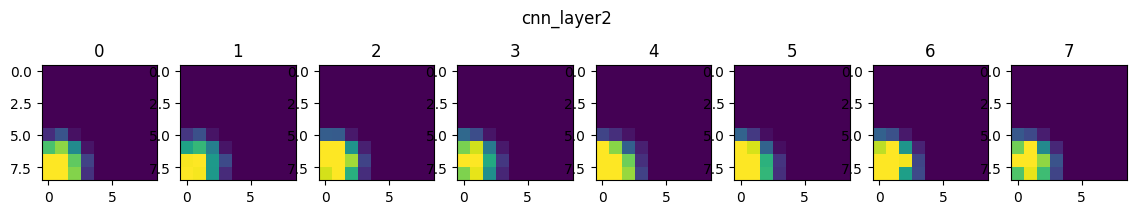

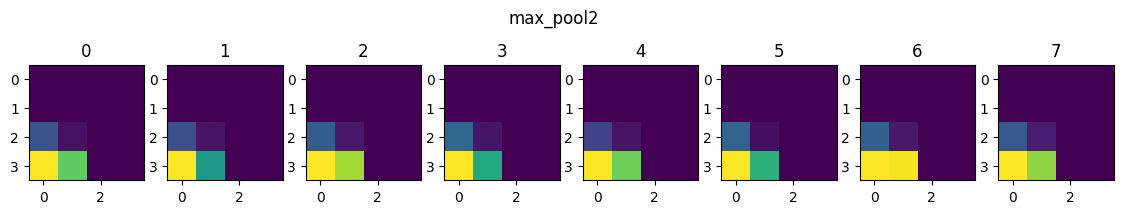

In [18]:
samples = [X[0], X[15]]
for sample in samples:
    # generate activations only for Conv2d and MaxPool2d layers
    display_feature_maps(sample)

Now, if we compare feature maps for detection of "X" and "O" - we can see that they are activated slightly differently by same kernels.  
When we look at the features maps, the "O" activates on opposite diagonal "\" instead of "/" as previously.  
It makes sense if you think about it: 
- for "X" shape, the diagonal pattern is activated in top-left, then middle, then bottom-right - which results in the feature map with a diagonal as well
- for "O" shape, the diagonal pattern is activated mostly in 2 places: top-right and bottom-left, but in fact much more than for "X", because "O" is wider around, so it activates same shape on the sides, meanwhile in the middle is not activated - this activation top-right and bottom-left is represented by "inverted" diagonal shape in feature map  
  another way to think about it is that "O" is kind of equivalent to "\\" for this kernel

## Heatmap


**Acquire outputs of CNN layer for which we want to display heatmap for**

In [53]:
model.to(device).eval()

# Get single sample, reformat into batch format
probe_sample = X[0].unsqueeze(dim=0).unsqueeze(dim=0).view(-1, 1, 18, 18).clone().to(device).requires_grad_(True)
print(probe_sample.shape)

# Get computational graphs from the model
output_features = model.extract_features(probe_sample.to(device))

# Extract just cnn layer and classificaiton output layer
cnn_layer_name, class_out_layer_name = "cnn_layer2", "output_activation"
cnn_layer = output_features[cnn_layer_name]
class_out_layer = output_features[class_out_layer_name]

# shapes
print(f"CNN output shape for '{cnn_layer_name}': {cnn_layer.shape}")
print("Predictions output shape: ", class_out_layer.shape)


torch.Size([1, 1, 18, 18])
extracting: Conv2d
extracting: MaxPool2d
extracting: Conv2d
extracting: MaxPool2d
extracting: Sigmoid
CNN output shape for 'cnn_layer2': torch.Size([1, 8, 9, 9])
Predictions output shape:  torch.Size([1, 1])


In [54]:
for name, layer in model.named_children():
    if name == cnn_layer_name:
        print(f"extracting: {layer}")
        target_layer = layer

extracting: Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [55]:
class SaveGradient:
    def __init__(self):
        self.grad = None
    def __call__(self, grad):
        self.grad = grad

# Register hook to capture the gradients
save_gradient = SaveGradient()
print(target_layer)

target_layer.register_full_backward_hook(lambda module, grad_in, grad_out: save_gradient(grad_out[0]))



Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [49]:
output = model(probe_sample)
print(output)

output.backward(gradient=one_hot_output, retain_graph=True)


tensor([[1.]], device='mps:0', grad_fn=<SigmoidBackward0>)


Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [56]:
print(save_gradient.grad)

None


Debugging graph :)

In [24]:
## pdf graph
from torchviz import make_dot
# Generate a visual graph of the model
dot = make_dot(model(probe_sample), params=dict(model.named_parameters()))
# Save the visual graph as a PNG file
dot.render("model_graph")

'model_graph.pdf'

In [25]:
# print("sample comp graph: ", probe_sample.grad_fn.next_functions)
print("cnn comp graph: ", cnn_layer.grad_fn)
print("class output comp graph - a: ", class_out_layer.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0])
if cnn_layer.grad_fn is class_out_layer.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0]:
    print("They're identical")
else:
    print("Not the same object")

cnn comp graph:  <ConvolutionBackward0 object at 0x17cc125f0>
class output comp graph - a:  <ConvolutionBackward0 object at 0x17dcaebc0>
Not the same object


**Acquire output of classification layer (predicted class specifically)**

In [26]:
# find predicted class
top_class_id = torch.argmax(class_out_layer, dim=1)
print('id: ', top_class_id.item())

# get predicted class
top_class_channel = class_out_layer[id]
print("top_class_channel: ", top_class_channel.item())


id:  0
top_class_channel:  1.0


**Calculate gradient of predicted class w.r.t. CNN layer**

In [27]:
# calculcate gradient
grads = torch.autograd.grad(top_class_channel, cnn_layer, retain_graph=True)[0] # output is single-element tuple (for single sample)
print("grads shape: ", grads.shape)
print("grads sum: ", torch.sum(grads).item())


grads shape:  torch.Size([1, 8, 9, 9])
grads sum:  0.0


**Generate heatmap**  
Gradient is calculated with respect to each pixel of the feature map.  
In order to generate heatmap, we first calculate mean to identify the power in which particular feature map affects the output class.  
Then we multiply that feature map by calculated weighted average.  
Lastly, we combine all feature maps by averaging the activations of each pixel.  

In [28]:

pooled_grads = torch.mean(grads, axis=(0, 2, 3))
print("p grads shape: ", pooled_grads.shape)
for i in range(pooled_grads.shape[-1]):
    cnn_layer[0, i, :, :] *= pooled_grads[i]
print("tested features shape in the end: ", cnn_layer.shape)
heatmap = -torch.mean(cnn_layer, axis=1).squeeze()
print("heatmap shape: ", heatmap.shape)
print("heatmap: ", heatmap)


p grads shape:  torch.Size([8])
tested features shape in the end:  torch.Size([1, 8, 9, 9])
heatmap shape:  torch.Size([9, 9])
heatmap:  tensor([[-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.]], device='mps:0',
       grad_fn=<NegBackward0>)


**Display heatmap**

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan]], device='mps:0',
       grad_fn=<DivBackward0>)


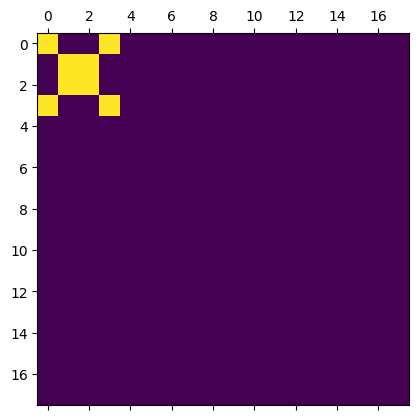

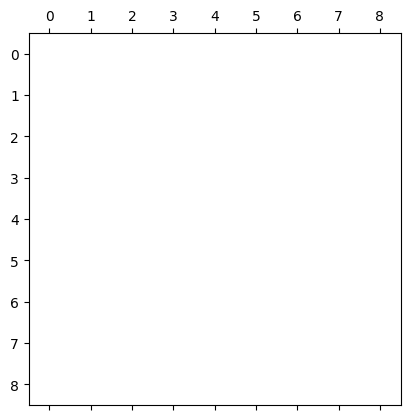

In [29]:

# remove non-positives and normalize to range (0, 1)
heatmap = torch.maximum(heatmap, torch.tensor(0))
heatmap /= torch.max(heatmap)
print(heatmap)

plt.matshow(probe_sample.to("cpu").detach().numpy().squeeze().squeeze())
plt.matshow(heatmap.to("cpu").squeeze().detach().numpy())

In [30]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Define a hook function to capture the gradients
class SaveGradient:
    def __init__(self):
        self.grad = None
    def __call__(self, grad):
        self.grad = grad

def grad_cam(model, image, target_layer, target_class):
    model.eval()

    # Register hook to capture the gradients
    save_gradient = SaveGradient()
    target_layer.register_backward_hook(lambda module, grad_in, grad_out: save_gradient(grad_out[0]))

    # Forward
    output = model(image)

    # Zero gradients first
    model.zero_grad()

    # Target for backprop
    one_hot_output = torch.zeros_like(output).to(image.device)
    one_hot_output[0][target_class] = 1

    # Backward pass to get gradients of target class output wrt. target layer
    output.backward(gradient=one_hot_output, retain_graph=True)

    # Get the gradients and feature maps from the target layer
    gradients = save_gradient.grad.data[0]
    activations = target_layer.output[0]  # Assuming the hook is on a Conv2d layer

    # Global Average Pooling of gradients
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Weighted combination of feature maps
    for i in range(gradients.size(0)):
        activations[i, :] *= pooled_gradients[i]

    # Average the channels of the activations and apply ReLU
    heatmap = torch.mean(activations, dim=0).cpu()
    heatmap = np.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= torch.max(heatmap)

    # Display heatmap
    plt.matshow(heatmap.squeeze())
    plt.show()

    return heatmap

In [31]:
# Example usage - Replace 'model' with your PyTorch model, 'image' with your input image, 'target_layer' with the layer you want to hook, and 'target_class' with the target output class
# model = ...  # Your model
# image = ...  # Your preprocessed input image with shape (1, C, H, W)
# target_layer = ...  # The convolutional layer you want the Grad-CAM for
# target_class = ...  # The index of the class in the output

heatmap = grad_cam(model, probe_sample, target_layer, top_class_id)

RuntimeError: Cannot use both regular backward hooks and full backward hooks on a single Module. Please use only one of them.

In [ ]:
target_layer = model.cnn_layer2
print(target_layer)